# Introduction

Panel exploratory analysis will be carried out in this notebook.

In [1]:
%load_ext autoreload
%autoreload


import pathlib
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


%matplotlib inline
sns.set_style("darkgrid")

# Constants

In [2]:
ROOT_PATH = pathlib.Path("../../")
DATA_PATH = ROOT_PATH.joinpath("_data")

SEED = 42

# Import data

In [3]:
train = pd.read_pickle(DATA_PATH.joinpath("train.pkl"))

# EDA

Let's check how average sales have changed over time for individual stores. This will allow us to observe the trend and seasonal effects, if any exist.

In [4]:
monthly_sales = train.groupby(
    ["Store", "Year", "Month"]
)["Sales"].agg("mean").reset_index()

monthly_sales["Date"] = pd.to_datetime(
    monthly_sales["Year"] * 100 + monthly_sales["Month"],
    format="%Y%m"
)

monthly_sales.drop(
    ["Year", "Month"], axis="columns", inplace=True
)

avg_monthly_sales = monthly_sales.groupby("Date")["Sales"]\
                    .agg("mean").reset_index()

We will select at random 100 stores to plot their monthly average sales in the specified time period and plot as well the global trend curve by averaging all sales at the given month.

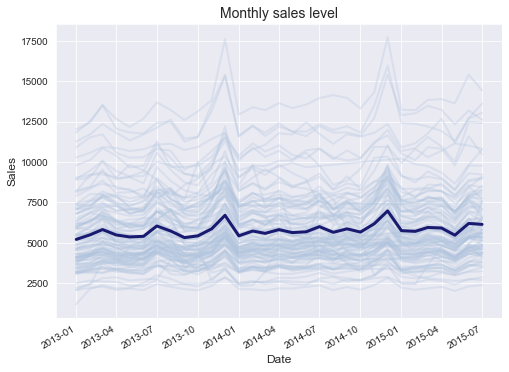

In [5]:
from futsal.utils import set_local_seed


fig, ax = plt.subplots(figsize=(8, 6))

with set_local_seed(SEED):
    stores_to_plot = np.random.choice(
        train["Store"].unique(), size=100, replace=False
    )

with warnings.catch_warnings():
    warnings.simplefilter(
        action="ignore", category=FutureWarning
    )
    for store in stores_to_plot:
        ax.plot(
            monthly_sales.loc[
                monthly_sales["Store"] == store, 
                "Date"
            ],
            monthly_sales.loc[
                monthly_sales["Store"] == store,
                "Sales"
            ],
            linewidth=2,
            alpha=.3,
            color="lightsteelblue"
        )

ax.plot(
    avg_monthly_sales["Date"],
    avg_monthly_sales["Sales"],
    linewidth=3,
    color="midnightblue"
)

ax.set_title("Monthly sales level", size=14)
ax.set_xlabel("Date", size=12)
ax.set_ylabel("Sales", size=12)

fig.autofmt_xdate()

We can clearly see that the process is almost stationary except the pre-Christmas seasonal effect. 
Let's find out from what day we are observing this growth.

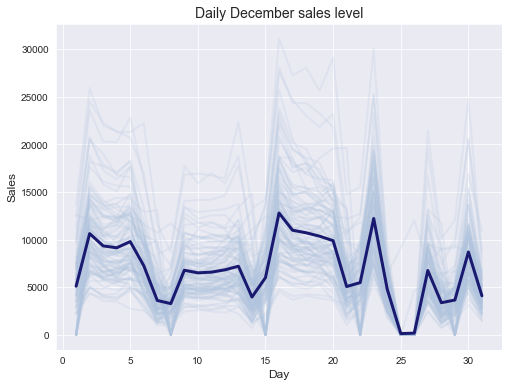

In [6]:
dec_daily_sales = train[train["Month"] == 12]\
                  .groupby(["Day", "Store"])["Sales"]\
                  .agg("mean")\
                  .reset_index()

avg_dec_daily_sales = train[train["Month"] == 12]\
                     .groupby("Day")["Sales"]\
                     .agg("mean")\
                     .reset_index()

fig, ax = plt.subplots(figsize=(8, 6))

with warnings.catch_warnings():
    warnings.simplefilter(
        action="ignore", category=FutureWarning
    )
    for store in stores_to_plot:
        ax.plot(
            dec_daily_sales.loc[
                dec_daily_sales["Store"] == store, 
                "Day"
            ],
            dec_daily_sales.loc[
                dec_daily_sales["Store"] == store,
                "Sales"
            ],
            linewidth=2,
            alpha=.2,
            color="lightsteelblue"
        )

ax.plot(
    avg_dec_daily_sales["Day"],
    avg_dec_daily_sales["Sales"],
    linewidth=3,
    color="midnightblue"
)

ax.set_title("Daily December sales level", size=14)
ax.set_xlabel("Day", size=12)
ax.set_ylabel("Sales", size=12)

plt.show()

We can perfectly see, as during the week to holidays (before St. Nicholas Day, as well as Christmas) note above average sales' jumps are observed.
This is predictable, because chemist's often organize gift wrapping actions from the beginning of December and it would be interesting to conduct A/B testing to see if these actions actually increase sales, or maybe correlation in this case does not mean causality.

## Promotions

We want to check whether promotions really matters.
To do so we will see how the promotion affects the level of sales broken down by weekdays.


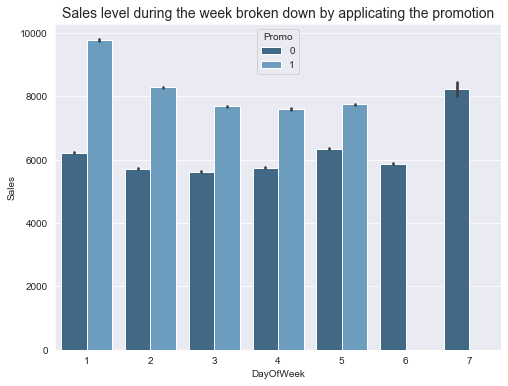

In [7]:
fig, ax = plt.subplots(figsize=(8, 6))


sns.barplot(
    x="DayOfWeek",
    y="Sales",
    data=train[train["Open"] == 1],
    hue="Promo",
    palette="Blues_d",
    ax=ax
)

ax.set_title(
    "Sales level during the week broken down "
    "by applicating the promotion",
    size=14
)

plt.show()

Promotions play a large role in creating sales levels, but we note that the strategy requires them to be applied only in the middle of the week, excluding weekends.

Let's find out other sales' drivers.

## SchoolHoliday

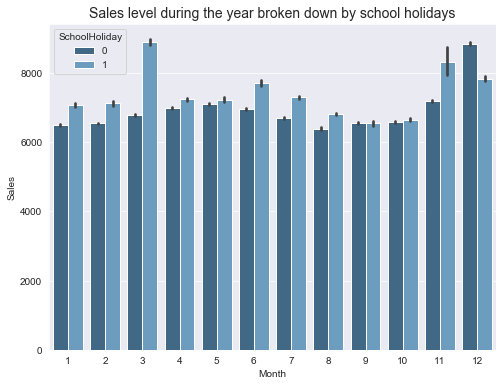

In [8]:
fig, ax = plt.subplots(figsize=(8, 6))


sns.barplot(
    x="Month",
    y="Sales",
    data=train[train["Open"] == 1],
    hue="SchoolHoliday",
    palette="Blues_d",
    ax=ax
)

ax.set_title(
    "Sales level during the year broken down "
    "by school holidays",
    size=14
)

plt.show()

We can see that March is special in some way and the phenomenon is then most observable.
We will try to answer this riddle.

In [9]:
cm = sns.light_palette("steelblue", as_cmap=True)

train.groupby(["SchoolHoliday", "Month"])["Sales"]\
.agg(["mean", "count"])\
.style.background_gradient(cmap=cm)

Plotting this table didn't help because no clear pattern is detected.
The numbers are typical for the period of the school year, while we note the actual increase in customers in March these days.
Let's take a day by day analyse of a single year.

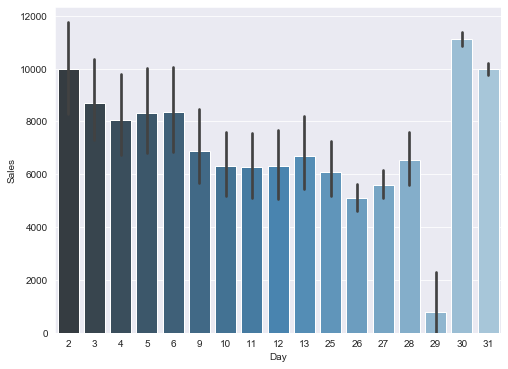

In [10]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.barplot(
    x="Day",
    y="Sales",
    data=train[
        (train["Year"] == 2015)
        & (train["Month"] == 3)
        & (train["SchoolHoliday"] == 1)
    ],
    palette="Blues_d",
    ax=ax
)

plt.show()

We can see that school off day depends on the region in which the store operates, it is probably influenced by the spring break, but without knowing the details it is hard to tell us why this month is so different from the others in terms of higher sales on school off days.

# Data preparation

We combine the data and create variables that are finally transferred to the model, to analyse their influence on the prediction.

Knowing that we can't use the customers count in the current day (because we don't know this number beforehand, we will use the **lagged customer variable** instead.

We want to also add the effect of the day after the break and the day before the break so we will add binary variables that will be keeping information about upcoming and past events (holidays, open shop, promotion).

In [11]:
from datetime import timedelta


train_lagged = train[[
    "Store", "Date", "Customers", "Open", 
    "Promo", "StateHoliday", "SchoolHoliday"
]].copy()
train_lagged["Date"] = train_lagged["Date"] + timedelta(days=1)
train_lagged.rename(
    columns={
        "Customers": "CustomersYesterday",
        "StateHoliday": "StateHolidayYesterday",
        "SchoolHoliday": "SchoolHolidayYesterday",
        "Open": "OpenYesterday",
        "Promo": "PromoYesterday"
    },
    inplace=True
)

train_accel = train[[
    "Store", "Date", "Open", 
    "StateHoliday", "SchoolHoliday"
]].copy()
train_accel["Date"] = train_accel["Date"] - timedelta(days=1)
train_accel.rename(
    columns={
        "Open": "OpenTomorrow",
        "StateHoliday": "StateHolidayTomorrow",
        "SchoolHoliday": "SchoolHolidayTomorrow"
    },
    inplace=True
)

train = train.merge(
    train_lagged, how="inner", on=["Store", "Date"]
)
train = train.merge(
    train_accel, how="inner", on=["Store", "Date"]
)

train.drop(
    ["Customers", "Year", "Month", "Day"],
    axis="columns", 
    inplace=True
)

Here we want to include detected seasonal effect of **increased pre-Christmas demand**. We will add a binary variable which will store information about whether there are holidays in a week.

In [12]:
def is_christmas_soon(col):
    current_year = col.year
    nicholas = pd.Timestamp(
        year=current_year,
        month=12,
        day=6
    )
    christmas = pd.Timestamp(
        year=current_year,
        month=12,
        day=24
    )
    nicholas_counter = len(pd.date_range(
        start=col, end=nicholas, freq="D"
    ))
    christmas_counter = len(pd.date_range(
        start=col, end=christmas, freq="D"
    ))
    is_nicholas_soon = 0 < nicholas_counter <= 7
    is_christmas_soon = 0 < christmas_counter <= 7
    if is_nicholas_soon or is_christmas_soon:
        return 1
    else:
        return 0

train["ChristmasInAWeek"] = train["Date"].apply(is_christmas_soon)

The last step before merging the store data is to OHE all of the categorical variables.
Our model will not include the time effect because, as we already have proven, our process is close to stationary, so the only variables to one-hot-encode are the `DayOfWeek` and `StateHoliday*`.

One-hot-encoded **Monday** and **0 - holiday** will be removed to avoid the problem of multicollinearity.

In [13]:
train = pd.get_dummies(
    data=train,
    columns=[
        "DayOfWeek",
        "StateHoliday",
        "StateHolidayYesterday",
        "StateHolidayTomorrow"
    ],
    drop_first=True
)

## Store data

We will create binary variables from passed opening / starting dates to 
crystallize those periods in which the phenomenon already existed.

In [14]:
store = pd.read_pickle(DATA_PATH.joinpath("store.pkl"))

df = train.merge(
    store.drop(
        [
            "Sales",
            "CompetitionOpenSinceMonth",
            "CompetitionOpenSinceYear",
            "Promo2",
            "Promo2SinceWeek",
            "Promo2SinceYear",
            "PromoInterval"
        ],
        axis="columns"
    ), 
    how="left", 
    on="Store"
)

We will create a feature `Promo2Active` by assigning 1 where promo was already active in the store and the month of sending the discount coupons is matching the current month, 0 otherwise.

Second created feature: `CompetitionActive` will base only on the **CompetitionOpenSinceDate** (is it older than the current date).

In [15]:
# Converting 3 to 0 to match the modulo function.
df.loc[df["PromoIntervalType"] == 3, "PromoIntervalType"] = 0

df["Promo2Active"] = 0
df.loc[
    ((df["Date"] - df["Promo2SinceDate"]).astype(int) > 0) 
    & (df["Date"].dt.month % 3 == df["PromoIntervalType"]), 
    "Promo2Active"
] = 1


df["CompetitionActive"] = np.where(
    (df["Date"] - df["CompetitionOpenSinceDate"]).astype(int) > 0, 1, 0
)

df.drop(
    [
        "CompetitionOpenSinceDate",
        "Promo2SinceDate",
        "PromoIntervalType"
    ],
    axis="columns",
    inplace=True
)

Lastly let's one more time OHE features obtained from merging `store.pkl`.

In [16]:
df = pd.get_dummies(
    data=df,
    columns=[
        "StoreType",
        "Assortment"
    ],
    drop_first=True
)

We will also remove observations where stores are closed, because it does not carry any information, it is obvious that the sale will then be zero. 

In [17]:
df.groupby("Open")["Sales"].agg(["mean", "max"])

,mean,max
Open,,
0,0.000000,0
1,6951.910087,41551


In [18]:
df = df[df["Open"] == 1]

# Pickling data

In [19]:
df.to_pickle(DATA_PATH.joinpath("panel.pkl"))